In [1]:
from lib import *

Pipeline = pipeline.Pipeline
RegressionValidator = pipeline.RegressionValidator

DatasetProvider = provider.DatasetProvider
DatasetUploader = provider.DatasetUploader

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm._tqdm_notebook import tqdm_notebook
from tqdm._tqdm_notebook import tqdm
tqdm_notebook.pandas()

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

/tmp/ipykernel_4235/2147512924.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [3]:
import pickle

def load_pickle(dataset, name):
    dataset.to_pickle(name + '.pkl')

def from_pickle(path):
    with open(path, 'rb') as reader:
        return pickle.load(reader)

In [29]:
task_df = {}

idx = from_pickle('../tmp/idx.pkl').rename({'id': 'object_id'}, axis=1)

task_df['train'] = from_pickle('../tmp/task_df_train.pkl')
task_df['dynamic'] = from_pickle('../tmp/id_sales.pkl')

In [5]:
errors = from_pickle('../tmp/xgb_error.pkl')

In [6]:
errors

(22.513062237516852,
 array([ 0.00368568,  0.00095156, -0.00434317, ...,  0.02526795,
         0.02414758, -0.05466482], dtype=float32),
          target
 id             
 54          0.0
 114         0.0
 174         0.0
 234         0.0
 294         0.0
 ...         ...
 1330036     0.0
 1330090     0.0
 1330142     0.0
 1330150     0.0
 1330156     0.0
 
 [422577 rows x 1 columns])

In [7]:
def get_statistics(report):
    stat = report[2]
    stat['residuals'] = report[1] - report[2].target
    stat['predicted'] = report[1]
    stat['object_id'] = report[2].index
    return stat

In [8]:
report = get_statistics(errors)

In [9]:
report = report.merge(idx, on='object_id', how='left')

Text(0.5, 1.0, 'Residual whisker')

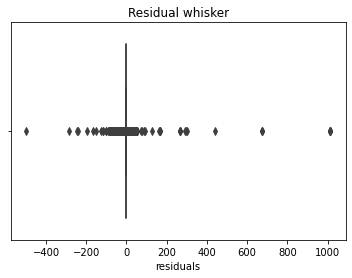

In [10]:
sns.boxplot(data=report, x='residuals').set_title('Residual whisker')

Wow, previously on validation residuals we see TOTAL underestimation

All non-zero points are a kind of outliers, so it's not as good as we want 

## Target - Prediction - Residual dependencies

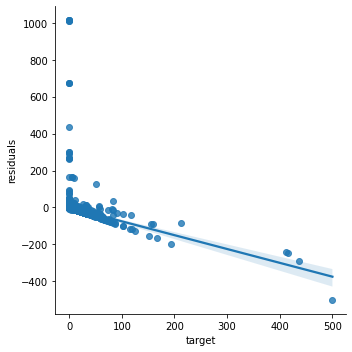

In [11]:
sns.lmplot(data=report, x='target', y='residuals')

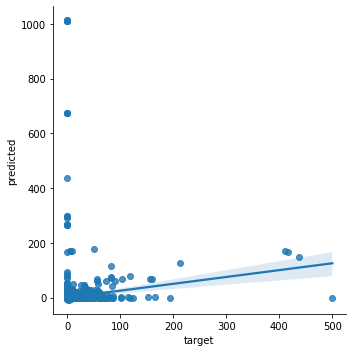

In [12]:
sns.lmplot(data=report, x='target', y='predicted')

### Base summary:

### 1) Obvious underfitting 
### 2) The key points of mistakes are:
 -  Underestimation by predicting zero values (maybe dynamicaly unpredictable peaks)
 -  Overestimation by predicting high values (maybe dynamicaly unpredictable high dynamic in previous month)
### 3) Model is unable to fit data (outliers were seen less then 100 times)

# Explore specific object groups

## 5% theory check

<AxesSubplot:xlabel='residuals'>

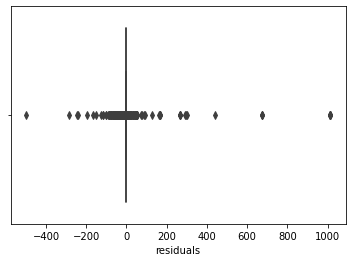

In [14]:
stable_residual_interval = report.reset_index().rename(columns={'index': 'id'}).merge(idx)
stable_residual_interval['abs_residuals'] = abs(stable_residual_interval['residuals'])
sns.boxplot(data=stable_residual_interval, x='residuals')

In [15]:
def causation_1_percent(residuals):


    giants = (residuals.sort_values('abs_residuals').tail(422))
    totals = (residuals.residuals @ residuals.residuals)

    giants['part'] = (residuals.residuals ** 2) / totals
    print(f'0.1% of objects cause {(giants.residuals @ giants.residuals)/(totals)} of error')
    
    return giants

In [16]:
giant_test =  causation_1_percent(stable_residual_interval)

0.1% of objects cause 0.9850818206356353 of error


### From this moment outliers are our target category! 

In [17]:

serieses = task_df['train'].groupby(['month_block', 'id']).item_cnt_day.sum().reset_index().set_index('id').index.value_counts().reset_index().rename({'id': 'appearence', 'index': 'id'}, axis=1)

In [18]:
top_50 = (giant_test.sort_values('part').reset_index()
    .groupby([
        'id', 'shop_id', 'item_id', 'shop_name', 'item_name'])
    .agg({
        'predicted': [np.mean],
        'target': [np.mean], 
        'part': [np.mean], 
        'abs_residuals': [np.mean, lambda x: np.mean(x)**2]})
    .sort_values(('part', 'mean'))
    .tail(50)
    )
top_50

predicted  \
                                                                                                                  mean   
id     shop_id item_id shop_name                       item_name                                                         
355711 9       11526   Выездная Торговля               Жетоны Fallout Dog Tag                                 0.022833   
347563 42      7224    СПб ТК "Невский Центр"          Uncharted: Натан Дрейк. Коллекция. Специальное ...    -0.008389   
419995 21      9250    Москва МТРЦ "Афи Молл"          Билет "ИгроМир 2015" - 3 октября 2015 [Цифровая...    72.662743   
417012 9       15047   Выездная Торговля               Меч 8Бит Алмазный Пиксельный 60см                     -0.419833   
417423 20      16843   Москва "Распродажа"             Очки пиксельные зеленые                               -0.017737   
341372 6       10201   Воронеж (Плехановская, 13)      Ведьмак 3: Дикая Охота - Дополнение "Каменные С...     0.173484   
420782 9       13246   Выездная Торговля               Комикс Дэдпул уничтожает вселенную Marvel             -0.063710   
419999 26      9250    Москва ТЦ "Ареал" (Беляево)     Билет "ИгроМир 2015" - 3 октября 2015 [Цифровая...    79.489113   
199117 9       4719    Выездная Торговля               Mad Max [PC, Jewel, русские субтитры]                  5.377065   
203509 9       7018    Выездная Торговля               Titanfall [PC, русская версия]                         0.078827   
408275 28      20949   Москва ТЦ "МЕГА Теплый Стан" II Фирменный пакет майка 1С Интерес белый (34*42) ...   126.315598   
420034 28      9254    Москва ТЦ "МЕГА Теплый Стан" II Билет "ИгроМир 2015" - 4 октября 2015 [Цифровая...    86.925110   
347553 25      7224    Москва ТРК "Атриум"             Uncharted: Натан Дрейк. Коллекция. Специальное ...     0.059402   
408269 21      20949   Москва МТРЦ "Афи Молл"          Фирменный пакет майка 1С Интерес белый (34*42) ...    68.996140   
408294 47      20949   Сургут ТРЦ "Сити Молл"          Фирменный пакет майка 1С Интерес белый (34*42) ...    68.875412   
419985 3       9250    Балашиха ТРК "Октябрь-Киномир"  Билет "ИгроМир 2015" - 3 октября 2015 [Цифровая...    94.154053   
348026 25      10202   Москва ТРК "Атриум"             Ведьмак 3: Дикая Охота - Дополнение "Каменные С...     0.327121   
202211 9       6503    Выездная Торговля               Sims 4 [PC, русская версия]                            0.067644   
348037 42      10202   СПб ТК "Невский Центр"          Ведьмак 3: Дикая Охота - Дополнение "Каменные С...     0.186856   
420788 20      13246   Москва "Распродажа"             Комикс Дэдпул уничтожает вселенную Marvel             -0.075421   
417418 9       16843   Выездная Торговля               Очки пиксельные зеленые                                0.033131   
403018 31      14839   Москва ТЦ "Семеновский"         МТГ(РУС): Истоки: Бустер арт. 864774                 176.694809   
341395 42      10201   СПб ТК "Невский Центр"          Ведьмак 3: Дикая Охота - Дополнение "Каменные С...     0.186856   
348141 6       11354   Воронеж (Плехановская, 13)      Дожить до рассвета. Extended Edition [PS4, русс...   169.790131   
348148 18      11354   Красноярск ТЦ "Июнь"            Дожить до рассвета. Extended Edition [PS4, русс...   169.542618   
348144 12      11354   Интернет-магазин ЧС             Дожить до рассвета. Extended Edition [PS4, русс...   170.555023   
344706 26      3445    Москва ТЦ "Ареал" (Беляево)     Far Cry 4 [PS4, русская версия]                      165.571457   
341384 25      10201   Москва ТРК "Атриум"             Ведьмак 3: Дикая Охота - Дополнение "Каменные С...     0.327121   
300988 9       4201    Выездная Торговля               Kaspersky Internet Security для Android Russian...    -3.041265   
408278 31      20949   Москва ТЦ "Семеновский"         Фирменный пакет майка 1С Интерес белый (34*42) ...   168.672577   
408289 42      20949   СПб ТК "Невский Центр"          Фирменный пакет майка 1С Инт

### Цирк уехал - клоуны остались. Я думаю тут и объяснять не нужно, что школьник - страшный сон для дата сатаниста (я посчитал, что тут 95-96% ошибки сидит)

Так же непонятен фетиш на пакеты

In [27]:
(giant_test.sort_values('part')
    .groupby([
        'shop_id', 'shop_name'])
    .agg({
        'part': [np.sum], 
        'abs_residuals': [np.sum]})
    .sort_values(('part', 'sum'))
    .tail(15))

,,part,abs_residuals
,,sum,sum
shop_id,shop_name,,
47,"Сургут ТРЦ ""Сити Молл""",0.001151,212.689133
22,Москва Магазин С21,0.001269,325.949004
21,"Москва МТРЦ ""Афи Молл""",0.002193,374.358098
18,"Красноярск ТЦ ""Июнь""",0.003477,372.315189
6,"Воронеж (Плехановская, 13)",0.004061,461.375079
26,"Москва ТЦ ""Ареал"" (Беляево)",0.004814,559.605361
20,"Москва ""Распродажа""",0.005587,1289.839584
16,"Коломна ТЦ ""Рио""",0.009181,371.854713


In [28]:
(giant_test.sort_values('part')
    .groupby([
        'item_id', 'item_name'])
    .agg({
        'part': [np.sum], 
        'abs_residuals': [np.sum]})
    .sort_values(('part', 'sum'))
    .tail(15))

,,part,abs_residuals
,,sum,sum
item_id,item_name,,
11354,"Дожить до рассвета. Extended Edition [PS4, русская версия]",0.008411,489.887772
10201,"Ведьмак 3: Дикая Охота - Дополнение ""Каменные Сердца"" (код загрузки, без диска) [PC, русская версия]",0.009277,1275.190699
9254,"Билет ""ИгроМир 2015"" - 4 октября 2015 [Цифровая версия]",0.022140,822.456461
9250,"Билет ""ИгроМир 2015"" - 3 октября 2015 [Цифровая версия]",0.027236,1314.337257
9246,"Билет ""ИгроМир 2015"" - 2 октября 2015 [Цифровая версия]",0.034531,1476.749722
9252,"Билет ""ИгроМир 2015"" - 4 октября 2015 (сайт) [Цифровая версия]",0.047686,673.546204
9253,"Билет ""ИгроМир 2015"" - 4 октября 2015 (сайт) УПР [Цифровая версия]",0.047752,674.009583
9255,"Билет ""ИгроМир 2015"" - 4 октября 2015 УПР [Цифровая версия]",0.047870,674.843628


## Dynamic exploration

In [57]:
full_df = task_df['train'].merge(idx)

def explore_plot(items, shops):
    _df = full_df[(full_df.item_name.isin(items)) & (full_df.shop_name.isin(shops))]
    return task_df['dynamic'][task_df['dynamic'].index.isin(_df.id)].transpose().plot(figsize=(10, 5))

<AxesSubplot:xlabel='month_block'>

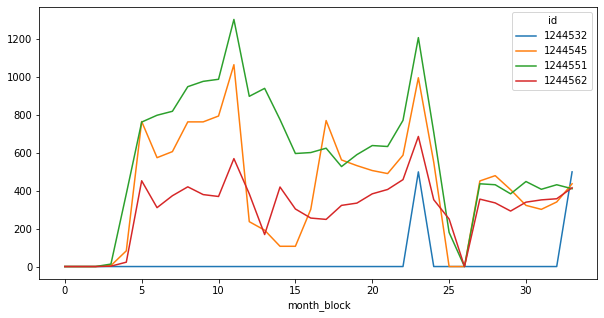

In [64]:
explore_plot(
    ['Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм'],
    [
        'Интернет-магазин ЧС',
        'Москва ТРК "Атриум"',
        'СПб ТК "Невский Центр"',
        'Москва ТЦ "Семеновский"',
    ]
)

<AxesSubplot:xlabel='month_block'>

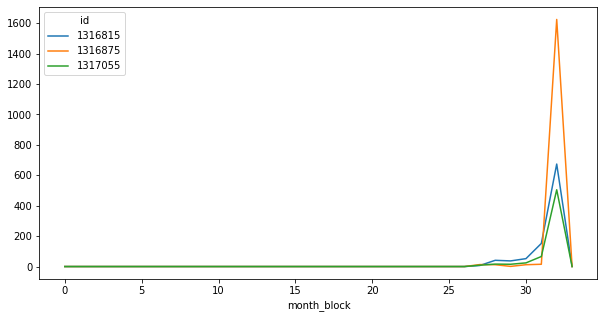

In [65]:
explore_plot(
    [
        'Билет "ИгроМир 2015" - 3 октября 2015 УПР [Цифровая версия',
        'Билет "ИгроМир 2015" - 3 октября 2015 (сайт) УПР [Цифровая версия]',
        'Билет "ИгроМир 2015" - 2 октября 2015 УПР [Цифровая версия]',
        'Билет "ИгроМир 2015" - 2 октября 2015 (сайт) УПР [Цифровая версия]	',
        'Билет "ИгроМир 2015" - 4 октября 2015 УПР [Цифровая версия]',
        'Билет "ИгроМир 2015" - 4 октября 2015 (сайт) УПР [Цифровая версия]	',
    ],
    [
        'Цифровой склад 1С-Онлайн',
    ]
)

<AxesSubplot:xlabel='month_block'>

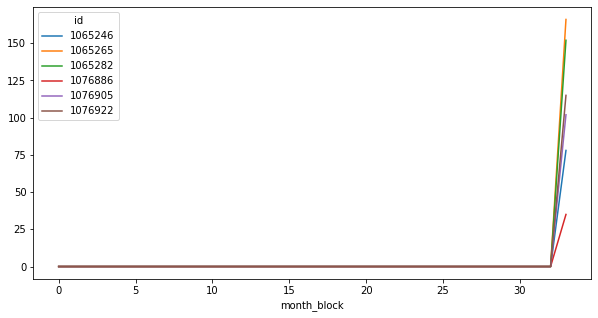

In [69]:
explore_plot(
    [
        'Ведьмак 3: Дикая Охота - Дополнение "Каменные Сердца" (код загрузки, без диска) [PC, русская версия]',
        'Ведьмак 3: Дикая Охота - Дополнение "Каменные Сердца" (код загрузки, без диска) [PS4, русская версия]'
    ],
    [
        'Москва ТРК "Атриум"',
        'СПб ТК "Невский Центр"',
        'Воронеж (Плехановская, 13)',
    ]
)

<AxesSubplot:xlabel='month_block'>

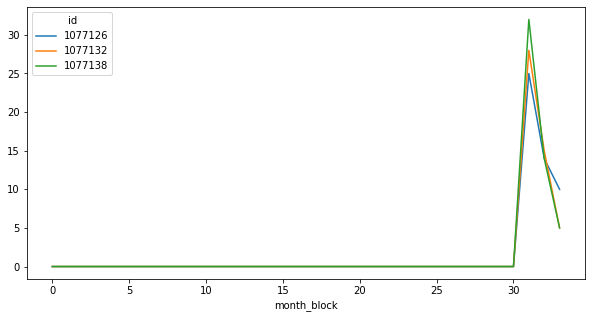

In [70]:
explore_plot(
    [
        'Дожить до рассвета. Extended Edition [PS4, русская версия]',
    ],
    [
        'Интернет-магазин ЧС',
        'Красноярск ТЦ "Июнь"',
        'Воронеж (Плехановская, 13)',
    ]
)